In [12]:
## keras 이용시 tensorflow 때문에 발생하는 warning을 가리기.
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import keras
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import preprocessing
from keras.utils import np_utils
from keras import optimizers

train = pd.read_csv("../data/titanic/train.csv")
test = pd.read_csv("../data/titanic/test.csv")
train = train.append(test) ## test 데이터도 학습에 이용.

# inplace=True 로 해야 모든 컬럼에 대해 fillna 가 이뤄짐.
# train.fillna(0, inplace=True) 
# test.fillna(0, inplace=True)

print(train.shape)
print(test.shape)

(1309, 12)
(418, 11)


In [2]:

# cols = PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked

# 데이터 전처리 : 학습에 필요없는 column 제거.
train.pop('Name'), test.pop('Name')
train.pop('Ticket'), test.pop('Ticket')
train.pop('Cabin'), test.pop('Cabin')
train.pop('PassengerId'), test.pop('PassengerId') # 제거하지 않으면 passengerId 가 높을수록 predicton value 가 높은 현상

# 비어 있는 cell 이 있는 row 는 제거. 
# inplace=True 로 설정해야, 모든 컬럼에 대해 적용됨. default:False
train.dropna(inplace=True)
# test.dropna(inplace=True) ## test 데이터는 

# 데이터 전처리 : One Hot Encoding
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
enc = encoder.fit(train[['Embarked']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Embarked']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Embarked']].astype(str))) , right_index=True, left_index=True)
enc = encoder.fit(train[['Sex']].astype(str))
train = pd.merge(train, pd.DataFrame(enc.transform(train[['Sex']].astype(str))) , right_index=True, left_index=True)
test = pd.merge(test, pd.DataFrame(enc.transform(test[['Sex']].astype(str))) , right_index=True, left_index=True)
train.pop('Embarked'), test.pop('Embarked')
train.pop('Sex'), test.pop('Sex')

# label
y_train = train[['Survived']]

# feature
train.pop('Survived')
x_train = train
x_test = test

x_train.head(5)



(712, 8)
(418, 7)


,Age,Fare,Parch,Pclass,SibSp,0_x,1,2,0_y
0,22.0,7.2500,0,3,1,0,0,1,1
1,38.0,71.2833,0,1,1,1,0,0,0
2,26.0,7.9250,0,3,0,0,0,1,0
3,35.0,53.1000,0,1,1,0,0,1,0
4,35.0,8.0500,0,3,0,0,0,1,1


In [3]:
# from sklearn.cluster import DBSCAN
# outlier_detection = DBSCAN(
#     eps = 0.5,
#     metric="euclidean",
#     n_jobs = -1)
# clusters = outlier_detection.fit_predict(train[['Fare']])
# clusters

In [4]:
live = len(y_train[y_train['Survived']==1])
death = len(y_train[y_train['Survived']==0])
print("live : " , live)
print("death : " , death)
print(
    "생존률 : " , live / (live + death)
)
y_train.head(5)

live :  182
death :  264
생존률 :  0.4080717488789238


,Survived
0,0.0
1,1.0
2,1.0
3,1.0
4,0.0


In [5]:
x_test.head(5)

,Pclass,Age,SibSp,Parch,Fare,0_x,1,2,0_y
0,3,34.5,0,0,7.8292,0,1,0,1
1,3,47.0,1,0,7.0000,0,0,1,0
2,2,62.0,0,0,9.6875,0,1,0,1
3,3,27.0,0,0,8.6625,0,0,1,1
4,3,22.0,1,1,12.2875,0,0,1,0


In [6]:

model = Sequential()
model.add(Dense(9, kernel_initializer = 'uniform',activation='relu', input_dim=len(x_train.columns)))
model.add(Dropout(0.1))
model.add(Dense(9, kernel_initializer = 'uniform',activation='relu'))
model.add(Dense(5, kernel_initializer = 'uniform',activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

# opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# opt = optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)
opt = optimizers.Adam(lr=0.0000005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

print(model.summary)

hist = model.fit(x_train, y_train, epochs=100, batch_size=30,validation_split=0.2)



<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a1e29f5c0>>
Train on 356 samples, validate on 90 samples
Epoch 1/100
356/356 [==============================] - 1s 2ms/step - loss: 0.6931 - acc: 0.5843 - val_loss: 0.6931 - val_acc: 0.6000
Epoch 2/100
356/356 [==============================] - 0s 92us/step - loss: 0.6931 - acc: 0.5758 - val_loss: 0.6931 - val_acc: 0.6111
Epoch 3/100
356/356 [==============================] - 0s 104us/step - loss: 0.6931 - acc: 0.5871 - val_loss: 0.6931 - val_acc: 0.6000
Epoch 4/100
356/356 [==============================] - 0s 114us/step - loss: 0.6931 - acc: 0.5702 - val_loss: 0.6931 - val_acc: 0.5889
Epoch 5/100
356/356 [==============================] - 0s 132us/step - loss: 0.6931 - acc: 0.5927 - val_loss: 0.6931 - val_acc: 0.5889
Epoch 6/100
356/356 [==============================] - 0s 107us/step - loss: 0.6931 - acc: 0.5983 - val_loss: 0.6931 - val_acc: 0.5778
Epoch 7/100
356/356 [==============================] -

356/356 [==============================] - 0s 68us/step - loss: 0.6931 - acc: 0.6067 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 61/100
356/356 [==============================] - 0s 70us/step - loss: 0.6931 - acc: 0.6236 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 62/100
356/356 [==============================] - 0s 63us/step - loss: 0.6931 - acc: 0.6152 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 63/100
356/356 [==============================] - 0s 68us/step - loss: 0.6931 - acc: 0.6292 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 64/100
356/356 [==============================] - 0s 60us/step - loss: 0.6931 - acc: 0.6320 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 65/100
356/356 [==============================] - 0s 58us/step - loss: 0.6931 - acc: 0.6236 - val_loss: 0.6931 - val_acc: 0.5333
Epoch 66/100
356/356 [==============================] - 0s 61us/step - loss: 0.6931 - acc: 0.6180 - val_loss: 0.6931 - val_acc: 0.5222
Epoch 67/100
356/356 [==============================] - 0s 64us/step

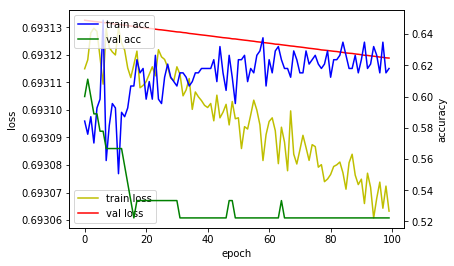

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [8]:
model.predict(x_test)

array([[ 0.49991205],
       [ 0.49992621],
       [ 0.49995232],
       [ 0.49990359],
       [ 0.4999024 ],
       [ 0.49988869],
       [ 0.49990728],
       [ 0.4999305 ],
       [ 0.49989203],
       [ 0.49991265],
       [        nan],
       [ 0.49995899],
       [ 0.49993056],
       [ 0.49997348],
       [ 0.4999994 ],
       [ 0.49992716],
       [ 0.49992287],
       [ 0.49989429],
       [ 0.4999024 ],
       [ 0.49992502],
       [ 0.50000972],
       [ 0.49987522],
       [        nan],
       [ 0.49992639],
       [ 0.49997509],
       [ 0.49993765],
       [ 0.49992973],
       [ 0.49989608],
       [ 0.49995923],
       [        nan],
       [ 0.4999578 ],
       [ 0.49992895],
       [ 0.49992722],
       [        nan],
       [ 0.4999572 ],
       [ 0.49989131],
       [        nan],
       [ 0.49989769],
       [ 0.49990234],
       [        nan],
       [ 0.49992466],
       [        nan],
       [ 0.49992007],
       [ 0.49991882],
       [ 0.49998987],
       [ 0

In [9]:
pred = model.predict_classes(x_test)
live = len([x for x in pred.ravel() if x==1])
death = len([x for x in pred.ravel() if x==0])
print("live : " , live)
print("death : " , death)
print("생존율 : ", live / (live + death))
# pred

live :  22
death :  396
생존율 :  0.05263157894736842


In [10]:
df_pred = pd.read_csv("../data/titanic/gender_submission.csv")
df_pred[['Survived']] = pred
# df_pred

In [11]:
df_pred.to_csv('result.csv', index=False)